In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

# Prerequisites
Please make sure the following Python distributions and packages were installed.

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [seaborn](https://seaborn.pydata.org)

You'll also need to create the following sub-folders in your working folder:

* data
   
   To store all the data files downloaded from Lending Club
   To store processed data file

## Load Data

In [2]:
df = pd.read_csv('data/loan_2014_processed.csv')

In [3]:
for col in df.columns.values:
    df.rename(columns={str(col):str.lower(str(col))}, inplace=True)


In [4]:
df.shape

(129487, 74)

## One-Hot-Encoding for Selected Categorical features

use pandas get_dummies to perform one hot encoding for selected categrorical features. 

In [5]:
dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [6]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [7]:
OHE_feature=list(df_dummy.columns.values)

In [8]:
len(OHE_feature)

22

In [9]:
df=pd.concat([df,df_dummy], axis=1 )

In [10]:
df.shape

(129487, 96)

In [11]:
df.columns.values

array(['id', 'initialliststatus', 'homeownership', 'purpose',
       'verificationstatus', 'issued', 'loanstatus', 'numtl120dpd2m',
       'totalbalexmort', 'accopenpast24mths', 'avgcurbal',
       'mosinoldrevtlop', 'openacc', 'numrevtlbalgt0', 'inqlast6mths',
       'totalilhighcreditlimit', 'mortacc', 'mthssincelastrecord',
       'tothicredlim', 'mthssincerecentbc', 'numtl90gdpd24m', 'numiltl',
       'totalrevhilim', 'mthssincerecentbcdlq', 'ficorangelow',
       'mthssincerecentrevoldelinq', 'numbcsats', 'numsats', 'bcopentobuy',
       'delinqamnt', 'percentbcgt75', 'taxliens', 'installment',
       'ficorangehigh', 'mosinoldilacct', 'numactvrevtl', 'numtloppast12m',
       'numactvbctl', 'chargeoffwithin12mths', 'numbctl', 'pubrec',
       'bcutil', 'pcttlnvrdlq', 'mthssincelastmajorderog', 'accnowdelinq',
       'totcollamt', 'mthssincerecentinq', 'mosinrcntrevtlop',
       'totalbclimit', 'pubrecbankruptcies', 'numoprevtl', 'revolbal',
       'annualinc', 'totalacc', 'mthssin

In [12]:
df.dtypes

id                                      int64
initialliststatus                      object
homeownership                          object
purpose                                object
verificationstatus                     object
issued                                 object
loanstatus                              int64
numtl120dpd2m                         float64
totalbalexmort                        float64
accopenpast24mths                     float64
avgcurbal                             float64
mosinoldrevtlop                       float64
openacc                               float64
numrevtlbalgt0                        float64
inqlast6mths                          float64
totalilhighcreditlimit                float64
mortacc                               float64
mthssincelastrecord                   float64
tothicredlim                          float64
mthssincerecentbc                     float64
numtl90gdpd24m                        float64
numiltl                           

In [13]:
df1 = df.drop(['initialliststatus', 'homeownership', 'purpose', 'verificationstatus', 'issued'], axis = 1)

### split dataset into train and test data

In [14]:
from sklearn.model_selection import train_test_split
target = df1['loanstatus']
X = df1.drop(['loanstatus', 'id'], axis= 1)
df_train, df_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=2018)

In [15]:
X.shape,target.shape

((129487, 89), (129487,))

In [16]:
df_train.shape, df_test.shape,target_train.shape, target_test.shape

((90640, 89), (38847, 89), (90640,), (38847,))

In [71]:
target.value_counts()

0    108778
1     20709
Name: loanstatus, dtype: int64

### Preliminary manually parameter tuning based on train-test split

In [17]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
X_train, X_valid, Y_train, Y_valid = train_test_split(df_train, target_train, 
                                                      test_size=0.3, random_state=2014)

In [19]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((63448, 89), (27192, 89), (63448,), (27192,))

In [20]:
dtrain = xgb.DMatrix(X_train, Y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, Y_valid, missing = np.NAN)
dtest = xgb.DMatrix(df_test, target_test, missing = np.NAN)

In [47]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 4, 
          "subsample": 0.9, 
          "colsample_bytree": 0.9,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 20,
          'scale_pos_weight': 6
         } 

In [48]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.674273	eval-auc:0.667548
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.680609	eval-auc:0.674621
[2]	train-auc:0.681216	eval-auc:0.675224
[3]	train-auc:0.684194	eval-auc:0.677255
[4]	train-auc:0.685011	eval-auc:0.677566
[5]	train-auc:0.685922	eval-auc:0.677904
[6]	train-auc:0.686205	eval-auc:0.677789
[7]	train-auc:0.686546	eval-auc:0.678332
[8]	train-auc:0.687333	eval-auc:0.679349
[9]	train-auc:0.6881	eval-auc:0.680046
[10]	train-auc:0.688661	eval-auc:0.68049
[11]	train-auc:0.689218	eval-auc:0.681072
[12]	train-auc:0.689914	eval-auc:0.681656
[13]	train-auc:0.690543	eval-auc:0.68209
[14]	train-auc:0.6911	eval-auc:0.682685
[15]	train-auc:0.691572	eval-auc:0.682919
[16]	train-auc:0.692126	eval-auc:0.683287
[17]	train-auc:0.692422	eval-auc:0.683504
[18]	train-auc:0.692888	eval-auc:0.683787
[19]	train-auc:0.693233	eval-auc:0.683845
[20]	train-auc:0.69354	eval-auc:0.6

[192]	train-auc:0.745478	eval-auc:0.701369
[193]	train-auc:0.745646	eval-auc:0.701365
[194]	train-auc:0.745848	eval-auc:0.701442
[195]	train-auc:0.746079	eval-auc:0.70142
[196]	train-auc:0.746218	eval-auc:0.701441
[197]	train-auc:0.746544	eval-auc:0.701542
[198]	train-auc:0.746619	eval-auc:0.70154
[199]	train-auc:0.746722	eval-auc:0.701606
[200]	train-auc:0.746965	eval-auc:0.701653
[201]	train-auc:0.747161	eval-auc:0.701709
[202]	train-auc:0.747305	eval-auc:0.701716
[203]	train-auc:0.747519	eval-auc:0.701673
[204]	train-auc:0.747677	eval-auc:0.701602
[205]	train-auc:0.747944	eval-auc:0.701605
[206]	train-auc:0.748125	eval-auc:0.701612
[207]	train-auc:0.748299	eval-auc:0.701639
[208]	train-auc:0.748452	eval-auc:0.701681
[209]	train-auc:0.748651	eval-auc:0.701705
[210]	train-auc:0.748839	eval-auc:0.701657
[211]	train-auc:0.749017	eval-auc:0.701633
[212]	train-auc:0.749094	eval-auc:0.701648
[213]	train-auc:0.749281	eval-auc:0.7017
[214]	train-auc:0.749574	eval-auc:0.701694
[215]	train-auc

[384]	train-auc:0.777196	eval-auc:0.702653
[385]	train-auc:0.777381	eval-auc:0.702698
[386]	train-auc:0.777523	eval-auc:0.702763
[387]	train-auc:0.777752	eval-auc:0.702849
[388]	train-auc:0.77792	eval-auc:0.702856
[389]	train-auc:0.778068	eval-auc:0.70287
[390]	train-auc:0.778239	eval-auc:0.702915
[391]	train-auc:0.778446	eval-auc:0.702939
[392]	train-auc:0.778638	eval-auc:0.702948
[393]	train-auc:0.778751	eval-auc:0.702948
[394]	train-auc:0.778908	eval-auc:0.702985
[395]	train-auc:0.779015	eval-auc:0.702996
[396]	train-auc:0.779075	eval-auc:0.703003
[397]	train-auc:0.779178	eval-auc:0.702992
[398]	train-auc:0.779288	eval-auc:0.702955
[399]	train-auc:0.779331	eval-auc:0.702949
[400]	train-auc:0.779466	eval-auc:0.702951
[401]	train-auc:0.779583	eval-auc:0.702928
[402]	train-auc:0.779719	eval-auc:0.702896
[403]	train-auc:0.779906	eval-auc:0.702918
[404]	train-auc:0.78019	eval-auc:0.702925
[405]	train-auc:0.780252	eval-auc:0.702926
[406]	train-auc:0.780307	eval-auc:0.702943
[407]	train-au

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print ("Area under the ROC curve - validation: %f" % roc_auc)
    print ("Area under the ROC curve - train: %f" % roc_auc_1)
    print ("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - valid(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train(AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test(AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.703182
Area under the ROC curve - train: 0.785955
Area under the ROC curve - test: 0.702890


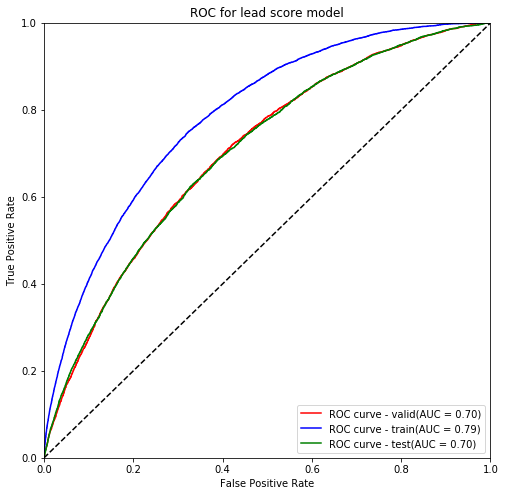

In [50]:
draw_ROC(gbm, dtrain, dvalid, dtest, Y_train, Y_valid, target_test)

### Distribution of predicted values

In [25]:
y_pred = gbm.predict(dtest)

In [26]:
print (y_pred.max(), y_pred.min(), y_pred.mean())

0.766898 0.00979131 0.159543


### Feature importance

In [27]:
importance=gbm.get_fscore()

In [28]:
df_importance = pd.DataFrame(list(importance.items()), columns=['feature', 'fscore'], index = None)
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [29]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
3,dti,0.045516
1,annualinc,0.041973
10,installment,0.039248
7,intrate,0.033252
19,mosinoldrevtlop,0.030799
0,subgrade,0.030526
2,avgcurbal,0.030253
23,mosinoldilacct,0.029981
34,bcutil,0.028346
42,zipcode,0.028073


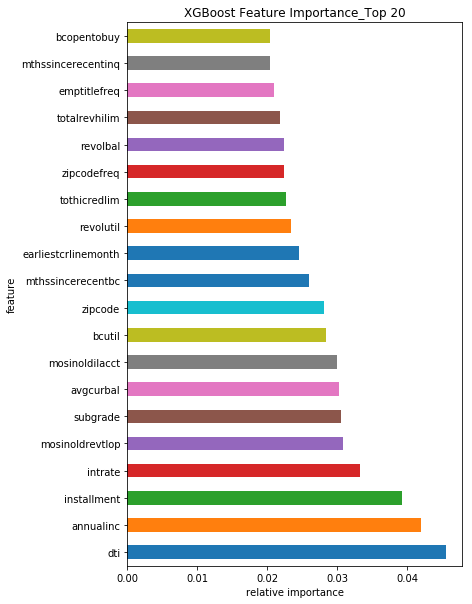

In [30]:
plt.figure(figsize=(32, 24))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance_Top 20')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [31]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
5,grade,0.009812


In [32]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
0,subgrade,0.030526


In [33]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
7,intrate,0.033252


In [34]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
22,loanamnt,0.018261


Text(0.5,0,'relative importance')

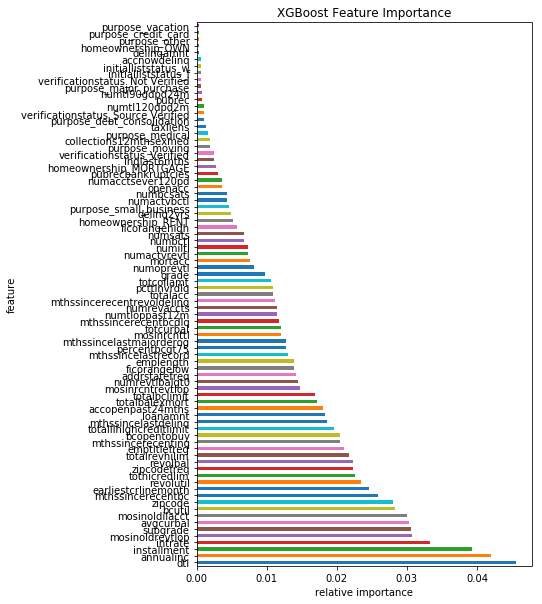

In [35]:
plt.figure(figsize=(32, 60))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [ ]:
from bayes_opt import BayesianOptimization

train_x = X
train_y = target

xgtrain = xgb.DMatrix(train_x, label = train_y, missing = np.NAN)

def xgb_evaluate(min_child_weight,
                colsample_bytree,
                max_depth,
                subsample,
                gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False
    
    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round = 100000,
                       nfold = 3,
                       metrics = {'auc'},
                       seed = 1234,
                       callbacks = [xgb.callback.early_stop(50)]
                      )
    
    print (cv_result)
    
    return cv_result['test-auc-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth':(3, 6),
                              'min_child_weight': (15, 25),
                              'colsample_bytree': (0.2, 0.4),
                              'subsample': (0.75, 1),
                              'gamma': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points = 5, n_iter = 40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[523]	train-auc:0.794571+0.00114664	test-auc:0.705233+0.00141859

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.666550      0.001962        0.673988       0.000268
1         0.673487      0.001136        0.682623       0.002012
2         0.676491      0.001919        0.688052       0.000896
3         0.678746      0.000142        0.690013       0.000660
4         0.680872      0.001037        0.693275       0.001984
5         0.682105      0.001040        0.695277       0.001722
6         0.682881      0.000875        0.696158       0.001795
7         0.683

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[417]	train-auc:0.785824+0.000742728	test-auc:0.705524+0.00173363

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.666597      0.001646        0.673989       0.000395
1         0.673211      0.000828        0.682006       0.001161
2         0.675891      0.001040        0.686944       0.000525
3         0.678168      0.000452        0.689288       0.000592
4         0.680588      0.000481        0.693055       0.001634
5         0.681718      0.000335        0.694799       0.000998
6         0.682975      0.000369        0.696055       0.001261
7         0.684052      0.000912        0.696882       0.001469
8         0.684453      0.000464        0.697221       0.000721
9         0.685393      0.000861        0.698737       0.000534
10        0.685296      0.001172        0.698925       0.00083

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[501]	train-auc:0.794654+0.000443984	test-auc:0.705426+0.00119961

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.666278      0.001767        0.673415       0.000407
1         0.671704      0.001385        0.680055       0.003083
2         0.675425      0.001962        0.687332       0.003263
3         0.678621      0.000966        0.690071       0.003140
4         0.679651      0.001092        0.691930       0.003263
5         0.680343      0.000519        0.693489       0.002583
6         0.681760      0.000830        0.694709       0.002521
7         0.683233      0.000439        0.695685       0.002195
8         0.683697      0.000536        0.696322       0.001813
9         0.684053      0.000689        0.697633       0.000656
10        0.684497      0.000803        0.698090       0.00029

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.41832754e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


   0.6676 |      5.0385 |            15.8924 |      0.8392 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1052]	train-auc:0.760853+0.000299497	test-auc:0.706075+0.00130814

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.662336      0.000645        0.663553       0.000359
1          0.666315      0.000499        0.668114       0.000770
2          0.669504      0.001894        0.672309       0.001594
3          0.671510      0.002149        0.674090       0.001780
4          0.673974      0.001907        0.677063       0.001683
5          0.674817      0.001294        0.678476       0.000534
6

    7 | 13m37s |    0.70644 |             0.3945 |    1.9950 |      3.0369 |            19.1328 |      0.7657 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[978]	train-auc:0.756749+0.000159599	test-auc:0.706196+0.00114301

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.662266      0.000673        0.663590       0.000401
1         0.666871      0.001234        0.668991       0.001804
2         0.669695      0.001315        0.672818       0.000716
3         0.671688      0.001390        0.674324       0.001064
4         0.674061      0.001132        0.677236       0.001305
5         0.674743      0.000807        0.678347       0.000432
6         0.675198      0.000326        0.678889       0.000919
7         0.675831      0.000755        0.679374       0.000780
8         0.675927      0.000623        0.679438       0.000507
9         0.6

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014142]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


 |    0.0741 |      3.1489 |            21.6957 |      0.9842 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1088]	train-auc:0.761242+0.000224389	test-auc:0.706334+0.00118829

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.662336      0.000645        0.663553       0.000359
1          0.666912      0.001283        0.668957       0.001847
2          0.669802      0.001205        0.672801       0.000686
3          0.671665      0.001186        0.674376       0.001058
4          0.674075      0.001208        0.677271       0.001319
5          0.674843      0.000750        0.678436       0.000377
6          0.675298      0.000248        0.679050       0.000847
7          0.675908      0.000717        0.679460       0.000770
8          0.675954      0.000625        0.679507       0.000494
9          0.676750      0.001699        0.680431 

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.45302329e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00381796]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


 |             0.3959 |    1.6972 |      3.0723 |            18.7129 |      0.9747 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[979]	train-auc:0.756754+0.000250349	test-auc:0.70646+0.000398976

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.661614      0.001060        0.663232       0.000408
1         0.665950      0.000852        0.667004       0.002452
2         0.670542      0.002705        0.672765       0.004344
3         0.672584      0.001922        0.674569       0.003615
4         0.673590      0.001604        0.676239       0.003711
5         0.674945      0.001330        0.677953       0.003529
6         0.675889      0.001707        0.678959       0.003580
7         0.676734      0.001157        0.679650       0.002661
8         0.677009      0.000587        0.680124       0.002106
9         0.677506      0.000461        

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00294654]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.26054729e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


            0.3180 |    0.1312 |      3.0368 |            17.5444 |      0.7510 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1096]	train-auc:0.760276+0.000132142	test-auc:0.706297+0.00105083

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.661842      0.000973        0.663194       0.000155
1          0.665405      0.000874        0.667000       0.002014
2          0.670108      0.001295        0.673171       0.002935
3          0.672058      0.000964        0.674881       0.002747
4          0.673044      0.000331        0.676525       0.002630
5          0.674217      0.000432        0.678254       0.002925
6          0.675301      0.000835        0.679232       0.002959
7          0.675980      0.000549        0.679680       0.002396
8          0.676317      0.000337        0.680122       0.001998
9          0.677331      0.00088

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -5.49351098e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00091179]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.06408261e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


            0.2974 |    0.2972 |      3.5198 |            18.7404 |      0.9405 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1041]	train-auc:0.760267+4.32974e-05	test-auc:0.706457+0.00120455

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.661798      0.000492        0.663390       0.000587
1          0.666570      0.000558        0.668063       0.001147
2          0.669887      0.001545        0.672288       0.001071
3          0.671415      0.002003        0.673759       0.001669
4          0.673974      0.001367        0.676960       0.001206
5          0.675240      0.000839        0.678727       0.000394
6          0.675876      0.000629        0.679326       0.001018
7          0.676338      0.000948        0.679653       0.000595
8          0.676375      0.000703        0.679652       0.000466
9          0.677073      0.00129

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00283943]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00053561]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00049127]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1025]	train-auc:0.75978+0.000394175	test-auc:0.706496+0.000535584

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.661495      0.001193        0.663282       0.000489
1          0.666792      0.000521        0.668282       0.001412
2          0.669688      0.001306        0.672357       0.000736
3          0.671609      0.001340        0.674122       0.001045
4          0.673659      0.001737        0.676954       0.001582
5          0.675451      0.001101        0.678754       0.000672
6          0.676310      0.000772        0.679571       0.001183
7          0.676749      0.000946        0.679882       0.000859
8          0.676939      0.001062        0.680260       0.001041
9          0.677343      0.001440        0.680933       0.000439
10         0.677510      0.001513        0.681227 

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.18984342e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00484324]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.49257961e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated 

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[877]	train-auc:0.752772+0.000619306	test-auc:0.706094+0.000930915

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.661809      0.000729        0.663543       0.000467
1         0.666717      0.001079        0.668335       0.001809
2         0.671169      0.002274        0.674229       0.002714
3         0.673007      0.001140        0.675900       0.001776
4         0.674607      0.001651        0.678525       0.002371
5         0.675842      0.001016        0.679748       0.001795
6         0.676601      0.001381        0.680412       0.002471
7         0.677104      0.001143        0.680702       0.001937
8         0.677612      0.000579        0.681179       0.001489
9         0.678059      0.000750        0.681793       0.000391
10        0.678087      0.001085        0.681960       0.0004

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1076]	train-auc:0.760066+0.000189896	test-auc:0.706637+0.000902353

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.662033      0.000844        0.663562       0.000370
1          0.665802      0.001204        0.667997       0.000872
2          0.669277      0.001840        0.672106       0.001268
3          0.671378      0.002275        0.673969       0.001589
4          0.673545      0.002263        0.676891       0.001731
5          0.674690      0.001314        0.678661       0.000539
6          0.675653      0.000813        0.679490       0.000605
7          0.676106      0.001204        0.679641       0.000398
8          0.676481      0.001303        0.680128       0.000824
9          0.677033      0.001531        0.681028       0.000667
10         0.677108      0.001858        0.681234

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00021967]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[575]	train-auc:0.801445+0.000821434	test-auc:0.705588+0.000856933

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.667556      0.001916        0.674502       0.000248
1         0.673709      0.000975        0.682475       0.001298
2         0.676558      0.001939        0.687526       0.000365
3         0.678763      0.001054        0.689677       0.000791
4         0.681163      0.001776        0.693363       0.001439
5         0.682386      0.001861        0.695335       0.001082
6         0.683255      0.001463        0.696299       0.001498
7         0.683971      0.001731        0.696889       0.001723
8         0.684653      0.001573        0.697508       0.001709
9         0.685292      0.001183        0.698949       0.001221
10        0.685347      0.001593        0.699132       0.0014

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[731]	train-auc:0.777797+0.00026531	test-auc:0.706089+0.00118493

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.666491      0.000944        0.669129       0.000388
1         0.672175      0.001544        0.676206       0.002411
2         0.674796      0.001279        0.680567       0.000312
3         0.676462      0.000659        0.682493       0.000991
4         0.678628      0.000890        0.685590       0.001469
5         0.679148      0.000677        0.686668       0.000621
6         0.679684      0.000528        0.687195       0.000989
7         0.680651      0.001022        0.687754       0.001018
8         0.681073      0.001232        0.688285       0.001223
9         0.681672      0.001654        0.689114       0.000780
10        0.681858      0.001944        0.689273       0.001144

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00047911]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[610]	train-auc:0.79996+0.000809561	test-auc:0.705679+0.000762662

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.663753      0.003747        0.668859       0.003178
1         0.670063      0.001401        0.676860       0.001157
2         0.675875      0.002278        0.685984       0.004098
3         0.678278      0.000719        0.688366       0.003272
4         0.679388      0.000599        0.690294       0.003196
5         0.680570      0.001114        0.692743       0.003117
6         0.681564      0.001499        0.693579       0.003277
7         0.682600      0.000734        0.694722       0.002268
8         0.682534      0.000910        0.694920       0.002171
9         0.682355      0.001470        0.695660       0.001311
10        0.683592      0.000800        0.697268       0.00167

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00110228]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[763]	train-auc:0.747828+0.000206187	test-auc:0.7061+0.00102403

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.661614      0.001060        0.663232       0.000408
1         0.666092      0.000791        0.667677       0.001749
2         0.669144      0.000883        0.671803       0.000459
3         0.671456      0.001500        0.673705       0.001595
4         0.673707      0.000479        0.676710       0.000737
5         0.675323      0.000298        0.678512       0.000757
6         0.675980      0.000571        0.679146       0.001347
7         0.676421      0.000506        0.679511       0.000875
8         0.676796      0.000501        0.680053       0.000624
9         0.677320      0.001538        0.680653       0.000786
10        0.677795      0.001283        0.681131       0.000534


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00296651]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  5.99426457e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[751]	train-auc:0.779244+0.000331447	test-auc:0.706588+0.000886321

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.665709      0.001238        0.668444       0.000385
1         0.671392      0.000670        0.674919       0.002395
2         0.674524      0.000399        0.679432       0.000717
3         0.676134      0.001537        0.681286       0.001268
4         0.678345      0.000100        0.684607       0.001573
5         0.679665      0.000394        0.686256       0.001051
6         0.680620      0.000537        0.687063       0.001477
7         0.681342      0.000522        0.687621       0.001177
8         0.681806      0.000629        0.688277       0.000949
9         0.682124      0.001108        0.688901       0.000301
10        0.682234      0.001304        0.689064       0.0005

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  6.83411781e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[455]	train-auc:0.785465+0.000727079	test-auc:0.705414+0.00161557

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.665953      0.002204        0.673081       0.000171
1         0.674359      0.001555        0.681754       0.002249
2         0.677384      0.001835        0.687425       0.000582
3         0.679394      0.001185        0.689681       0.001117
4         0.681952      0.001653        0.693295       0.001664
5         0.682698      0.001417        0.694897       0.000972
6         0.683542      0.001505        0.695959       0.001405
7         0.684531      0.001471        0.696718       0.001354
8         0.685018      0.001517        0.697489       0.001347
9         0.685629      0.001410        0.698600       0.000538
10        0.685861      0.001713        0.698949       0.00085

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00340526]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.49811507e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[849]	train-auc:0.751397+0.000245943	test-auc:0.706019+0.000790315

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.661614      0.001060        0.663232       0.000408
1         0.665950      0.000852        0.667004       0.002452
2         0.669843      0.003232        0.672531       0.004593
3         0.671959      0.002383        0.674383       0.003797
4         0.673024      0.002019        0.676019       0.003850
5         0.674545      0.001730        0.677787       0.003667
6         0.675509      0.002015        0.678782       0.003683
7         0.676380      0.001348        0.679460       0.002701
8         0.676704      0.000782        0.679997       0.002146
9         0.677220      0.000630        0.680676       0.001409
10        0.677499      0.000329        0.680980       0.0010

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -5.53687569e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  9.04970802e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00032588]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[517]	train-auc:0.797463+0.000454864	test-auc:0.705124+0.000853442

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.665574      0.002278        0.673037       0.000349
1         0.672850      0.001597        0.681215       0.001817
2         0.676501      0.001867        0.688202       0.002082
3         0.679431      0.000967        0.690578       0.001945
4         0.681224      0.002064        0.693804       0.002492
5         0.681765      0.002180        0.694889       0.001658
6         0.682836      0.002339        0.695924       0.002186
7         0.683784      0.001970        0.696567       0.001967
8         0.684320      0.001902        0.697330       0.001932
9         0.684846      0.001686        0.698484       0.001234
10        0.685057      0.001789        0.698779       0.0012

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00693205]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[522]	train-auc:0.799524+0.00123732	test-auc:0.705986+0.000707527

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.667423      0.001452        0.674698       0.000227
1         0.673627      0.001221        0.682797       0.001473
2         0.676819      0.002174        0.687970       0.000558
3         0.679117      0.001028        0.690128       0.000856
4         0.681421      0.001681        0.694122       0.001744
5         0.682547      0.001653        0.695854       0.001426
6         0.683325      0.001420        0.696760       0.001732
7         0.684140      0.001717        0.697326       0.001928
8         0.684703      0.001464        0.697929       0.001905
9         0.685253      0.001197        0.699232       0.001567
10        0.685465      0.001641        0.699472       0.00172

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00015803]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[576]	train-auc:0.767075+0.000523034	test-auc:0.705649+0.000878424

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.665743      0.002143        0.668507       0.000518
1         0.671698      0.000700        0.675265       0.001997
2         0.674854      0.001420        0.679678       0.000477
3         0.676883      0.001730        0.681710       0.001162
4         0.678590      0.001731        0.684721       0.001416
5         0.679866      0.001308        0.686609       0.000965
6         0.680717      0.001522        0.687238       0.001361
7         0.681296      0.001516        0.687693       0.001103
8         0.681928      0.001613        0.688316       0.000973
9         0.682528      0.001726        0.689199       0.000915
10        0.682572      0.001968        0.689217       0.0010

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0004552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[514]	train-auc:0.796756+0.000921242	test-auc:0.70529+0.00112002

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.667621      0.001135        0.675023       0.000475
1         0.674530      0.001200        0.683983       0.001705
2         0.677136      0.001382        0.688798       0.000526
3         0.679116      0.000746        0.690858       0.000746
4         0.681357      0.001489        0.694638       0.001728
5         0.682271      0.001694        0.696228       0.000965
6         0.683085      0.001354        0.697176       0.001193
7         0.683769      0.001448        0.697557       0.001378
8         0.684178      0.000842        0.697674       0.000718
9         0.685144      0.000988        0.699056       0.000877
10        0.685268      0.001244        0.699216       0.001015

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[872]	train-auc:0.749412+0.000626934	test-auc:0.705489+0.00111269

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.659035      0.002722        0.660151       0.001902
1         0.664864      0.000644        0.666161       0.001527
2         0.669528      0.001924        0.671698       0.002838
3         0.671589      0.001026        0.673590       0.002646
4         0.672750      0.001840        0.675006       0.002695
5         0.673413      0.001516        0.676437       0.002371
6         0.674490      0.003309        0.677806       0.003816
7         0.675438      0.002497        0.678975       0.003114
8         0.675710      0.002976        0.679818       0.003217
9         0.676094      0.003560        0.680371       0.003334
10        0.677524      0.002300        0.682011       0.00259

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00017356]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[490]	train-auc:0.787328+0.000556647	test-auc:0.705661+0.00142049

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.662809      0.003492        0.668539       0.002721
1         0.669273      0.001271        0.676766       0.001367
2         0.674358      0.002310        0.684208       0.002447
3         0.677409      0.000684        0.687200       0.002442
4         0.678478      0.001337        0.688763       0.002765
5         0.679268      0.000805        0.690832       0.001895
6         0.680419      0.002459        0.692214       0.003693
7         0.681647      0.001795        0.693798       0.003043
8         0.681645      0.002235        0.694681       0.002559
9         0.681972      0.003219        0.695595       0.002607
10        0.683581      0.001908        0.697491       0.00232

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  7.57280504e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[756]	train-auc:0.773721+6.43963e-05	test-auc:0.70594+0.00109076

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.662486      0.003102        0.665070       0.001776
1         0.668151      0.000487        0.671539       0.002075
2         0.673484      0.001944        0.677766       0.002234
3         0.675993      0.000949        0.680151       0.002188
4         0.676290      0.001197        0.681262       0.002139
5         0.676978      0.000898        0.682915       0.001494
6         0.678276      0.002687        0.684389       0.003388
7         0.677989      0.003162        0.684494       0.003604
8         0.678432      0.003821        0.685482       0.003743
9         0.678902      0.004731        0.686228       0.004233
10        0.680095      0.003511        0.687601       0.003609

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00020316]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[533]	train-auc:0.79541+0.000755695	test-auc:0.705574+0.000767281

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.666150      0.002400        0.672787       0.000311
1         0.673123      0.001291        0.681728       0.002004
2         0.676527      0.000724        0.687219       0.000424
3         0.678744      0.000874        0.689592       0.000968
4         0.681270      0.000774        0.693565       0.001818
5         0.682139      0.001288        0.695153       0.001369
6         0.683059      0.001263        0.696127       0.001672
7         0.684195      0.001206        0.696912       0.001509
8         0.684695      0.001003        0.697138       0.000784
9         0.685492      0.001068        0.698265       0.000274
10        0.685707      0.001230        0.698498       0.00047

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.36542798e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1237]	train-auc:0.764699+0.000498078	test-auc:0.705698+0.00064694

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.661608      0.000895        0.662609       0.000353
1          0.665536      0.001408        0.667110       0.002461
2          0.670545      0.001843        0.673941       0.003422
3          0.672592      0.001955        0.675480       0.003321
4          0.673326      0.001191        0.676776       0.003128
5          0.674318      0.001659        0.678735       0.003203
6          0.674720      0.002111        0.679063       0.003286
7          0.675130      0.001577        0.679463       0.002490
8          0.674852      0.002035        0.679333       0.002355
9          0.674973      0.003197        0.679704       0.002709
10         0.676277      0.001548        0.681205 

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00873207]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1041]	train-auc:0.755106+0.000135947	test-auc:0.705973+0.000895697

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.659220      0.002613        0.660404       0.001650
1          0.664537      0.000493        0.666343       0.001464
2          0.670470      0.002158        0.673278       0.003365
3          0.672290      0.001436        0.674810       0.002716
4          0.673632      0.001247        0.676576       0.002852
5          0.674451      0.001766        0.678245       0.003202
6          0.674701      0.002655        0.678586       0.003604
7          0.675296      0.001836        0.679119       0.002655
8          0.675065      0.002394        0.678976       0.002659
9          0.675075      0.002876        0.679183       0.002527
10         0.676441      0.001561        0.680720

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00192286]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[1086]	train-auc:0.757109+0.000286068	test-auc:0.70589+0.00129499

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.659220      0.002613        0.660404       0.001650
1          0.664793      0.000673        0.666239       0.001599
2          0.670802      0.001994        0.672948       0.003535
3          0.672649      0.000951        0.674532       0.002875
4          0.673954      0.001341        0.676284       0.003127
5          0.674501      0.000734        0.677587       0.002404
6          0.674878      0.001913        0.678325       0.003319
7          0.675411      0.001199        0.679154       0.002768
8          0.675464      0.002018        0.679452       0.003255
9          0.675705      0.002756        0.679816       0.003261
10         0.676831      0.001457        0.681111  

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00034797]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.0020729]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[516]	train-auc:0.798573+0.000455008	test-auc:0.704657+0.00114462

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.665117      0.001366        0.673397       0.000076
1         0.673296      0.001159        0.681811       0.001887
2         0.676412      0.001842        0.687788       0.000337
3         0.678576      0.000630        0.690047       0.001219
4         0.680703      0.001254        0.693447       0.001590
5         0.681953      0.001222        0.695110       0.000785
6         0.682781      0.001277        0.696006       0.001341
7         0.683729      0.001154        0.696626       0.001307
8         0.684057      0.000873        0.696759       0.000692
9         0.685046      0.000878        0.698147       0.000856
10        0.685143      0.001077        0.698394       0.00092

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00127682]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  4.26932238e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.


In [37]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by = 'score', ascending = False)
xgb_BO_scores.head(3)

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
39,0.382313,1.319984,3.030281,21.870943,0.751767,0.706629
13,0.393884,1.989558,3.431085,16.393226,0.758638,0.706627
10,0.396430,0.423053,4.319220,19.752877,0.982719,0.706505


In [38]:
%%time
params = {'objective': 'binary:logistic',
          'booster': 'gbtree',
          'eta': 0.05,
          'max_depth': 4,
          'min_child_weight': 25,
          'sub_sample': 0.756950,
          'colsample_bytree': 0.396082,
          'gamma': 0.227283,
          'seed': 1234,
          'nthread': -1,
          'silence': 1, 
          'eval_metric': 'auc',
          'scale_pos_weight': 6
        }

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_rounds = 10000
gbm = xgb.train(params, dtrain, num_boost_rounds, evals = watchlist, early_stopping_rounds = 50)

[0]	train-auc:0.632749	eval-auc:0.612387
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.651923	eval-auc:0.633659
[2]	train-auc:0.685374	eval-auc:0.672493
[3]	train-auc:0.682889	eval-auc:0.670721
[4]	train-auc:0.690899	eval-auc:0.680592
[5]	train-auc:0.692084	eval-auc:0.68409
[6]	train-auc:0.69176	eval-auc:0.684549
[7]	train-auc:0.691508	eval-auc:0.684981
[8]	train-auc:0.692004	eval-auc:0.685153
[9]	train-auc:0.692227	eval-auc:0.685047
[10]	train-auc:0.692752	eval-auc:0.685675
[11]	train-auc:0.692598	eval-auc:0.685315
[12]	train-auc:0.69307	eval-auc:0.685547
[13]	train-auc:0.693145	eval-auc:0.685652
[14]	train-auc:0.693268	eval-auc:0.685739
[15]	train-auc:0.694404	eval-auc:0.686466
[16]	train-auc:0.694439	eval-auc:0.686469
[17]	train-auc:0.694471	eval-auc:0.686393
[18]	train-auc:0.694395	eval-auc:0.686314
[19]	train-auc:0.694363	eval-auc:0.686184
[20]	train-auc:0.694386	eval-auc

[191]	train-auc:0.734039	eval-auc:0.701285
[192]	train-auc:0.734172	eval-auc:0.701276
[193]	train-auc:0.734522	eval-auc:0.701409
[194]	train-auc:0.734645	eval-auc:0.701422
[195]	train-auc:0.734861	eval-auc:0.701535
[196]	train-auc:0.734933	eval-auc:0.701522
[197]	train-auc:0.73502	eval-auc:0.701542
[198]	train-auc:0.735202	eval-auc:0.701615
[199]	train-auc:0.735367	eval-auc:0.701664
[200]	train-auc:0.735531	eval-auc:0.701635
[201]	train-auc:0.735582	eval-auc:0.701648
[202]	train-auc:0.735714	eval-auc:0.70166
[203]	train-auc:0.735826	eval-auc:0.7017
[204]	train-auc:0.735889	eval-auc:0.701734
[205]	train-auc:0.736002	eval-auc:0.701737
[206]	train-auc:0.736043	eval-auc:0.70176
[207]	train-auc:0.736188	eval-auc:0.7018
[208]	train-auc:0.736342	eval-auc:0.701798
[209]	train-auc:0.736437	eval-auc:0.701832
[210]	train-auc:0.736512	eval-auc:0.701846
[211]	train-auc:0.736542	eval-auc:0.701841
[212]	train-auc:0.736739	eval-auc:0.701846
[213]	train-auc:0.736959	eval-auc:0.701915
[214]	train-auc:0.

[383]	train-auc:0.75906	eval-auc:0.704833
[384]	train-auc:0.759086	eval-auc:0.704832
[385]	train-auc:0.759125	eval-auc:0.704854
[386]	train-auc:0.759221	eval-auc:0.704854
[387]	train-auc:0.759304	eval-auc:0.704852
[388]	train-auc:0.759459	eval-auc:0.704814
[389]	train-auc:0.759561	eval-auc:0.704819
[390]	train-auc:0.759639	eval-auc:0.704808
[391]	train-auc:0.759681	eval-auc:0.704824
[392]	train-auc:0.759797	eval-auc:0.704822
[393]	train-auc:0.759868	eval-auc:0.704831
[394]	train-auc:0.759964	eval-auc:0.704788
[395]	train-auc:0.760136	eval-auc:0.704888
[396]	train-auc:0.760262	eval-auc:0.704916
[397]	train-auc:0.760336	eval-auc:0.704917
[398]	train-auc:0.760498	eval-auc:0.70491
[399]	train-auc:0.760531	eval-auc:0.704915
[400]	train-auc:0.760615	eval-auc:0.704908
[401]	train-auc:0.760668	eval-auc:0.704881
[402]	train-auc:0.760811	eval-auc:0.704936
[403]	train-auc:0.760898	eval-auc:0.704958
[404]	train-auc:0.761043	eval-auc:0.704946
[405]	train-auc:0.761197	eval-auc:0.704966
[406]	train-a

[575]	train-auc:0.779278	eval-auc:0.705624
[576]	train-auc:0.779327	eval-auc:0.705626
[577]	train-auc:0.779453	eval-auc:0.705591
[578]	train-auc:0.7796	eval-auc:0.705616
[579]	train-auc:0.779719	eval-auc:0.705559
[580]	train-auc:0.779839	eval-auc:0.705574
[581]	train-auc:0.779863	eval-auc:0.705576
[582]	train-auc:0.779934	eval-auc:0.705586
[583]	train-auc:0.779996	eval-auc:0.705599
[584]	train-auc:0.780096	eval-auc:0.705601
[585]	train-auc:0.780198	eval-auc:0.705621
[586]	train-auc:0.780326	eval-auc:0.705656
[587]	train-auc:0.780501	eval-auc:0.705703
[588]	train-auc:0.780612	eval-auc:0.705698
[589]	train-auc:0.780682	eval-auc:0.7057
[590]	train-auc:0.780759	eval-auc:0.705696
[591]	train-auc:0.780904	eval-auc:0.705704
[592]	train-auc:0.781058	eval-auc:0.705682
[593]	train-auc:0.781176	eval-auc:0.705631
[594]	train-auc:0.781212	eval-auc:0.705624
[595]	train-auc:0.781285	eval-auc:0.70563
[596]	train-auc:0.781479	eval-auc:0.705674
[597]	train-auc:0.781501	eval-auc:0.705686
[598]	train-auc:

Area under the ROC curve - validation: 0.705882
Area under the ROC curve - train: 0.776550
Area under the ROC curve - test: 0.703960


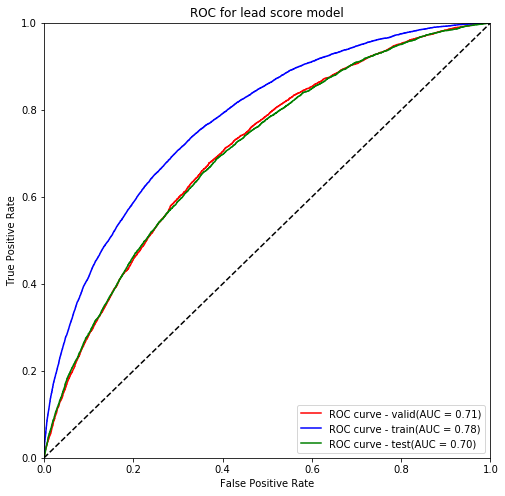

In [39]:
draw_ROC(gbm, dtrain, dvalid, dtest, Y_train, Y_valid, target_test)

Random Forest

In [91]:
from sklearn.model_selection import train_test_split
Y = df1['loanstatus']
X = df1.drop(['loanstatus', 'id'], axis= 1)
X = X.fillna(X.mean())
rf_train, rf_test, rf_y_train, rf_y_test = train_test_split(X, Y, test_size=0.3, random_state=2018)

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# RF = RandomForestClassifier(max_features=5, min_samples_leaf=10, min_samples_split=2, 
#                             bootstrap=True, criterion='gini', max_depth=7, 
#                             n_estimators=100, random_state=2018, class_weight = {0:20, 1:1})
RF = RandomForestClassifier(class_weight = {0:5, 1:1})

RF = RF.fit(rf_train, rf_y_train)
y_pred = RF.predict(rf_test)
print (metrics.classification_report(rf_y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.97      0.91     32696
          1       0.32      0.06      0.11      6151

avg / total       0.76      0.83      0.78     38847



In [85]:
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, _ = roc_curve(rf_y_test, y_pred)

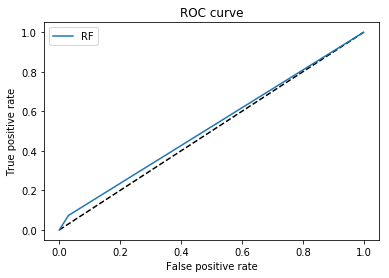

In [86]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [68]:
![Image of Yaktocat](https://octodex.github.com/images/yaktocat.png)
def search_model(x_train, y_train, est, param_grid, n_jobs, cv):
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring = 'f1_weighted',
                                     verbose = 10,
                                     n_jobs = n_jobs,
                                     iid = True,
                                     cv = cv)
    # Fit Grid Search Model
    model.fit(x_train, y_train)   
    return model

In [70]:
param_grid = {'n_estimators':[100,300,500],
             'criterion':['gini', 'entropy'],
             'class_weight': [{0:5, 1:1}]}

RF = search_model(X.values
            , Y.values
            , RandomForestClassifier()
            , param_grid
            , -1
            , 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100 ...
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100 ...
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100 ...
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100, score=0.7816858802772411, total= 2.7min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100, score=0.7711323969464426, total= 2.7min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100, score=0.7742271444599799, total= 2.7min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=100, score=0.7802885150820831, total= 2.7min
[CV] cl

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.5min


[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300, score=0.7822508590052856, total= 8.0min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300, score=0.7732197727808369, total= 8.1min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300, score=0.7807623205232512, total= 8.2min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300, score=0.7721894652810773, total= 8.4min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=300, score=0.7731564203841875, total= 8.6min


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 20.3min


[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500, score=0.7816908661677292, total=14.6min
[CV] class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500 ...
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500, score=0.7791626219878635, total=14.9min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100 
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100, score=0.7731452357004571, total= 2.3min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100 
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500, score=0.7735677499522546, total=14.5min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100 
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100, score=0.7688985101495056, total= 2.6min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100 
[CV]  class_weight={0: 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 34.7min


[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=100, score=0.7695106142203252, total= 2.6min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300 
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500, score=0.7716190959250085, total=14.2min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300 
[CV]  class_weight={0: 85, 1: 15}, criterion=gini, n_estimators=500, score=0.7731192808078196, total=13.0min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300 
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300, score=0.771458612592496, total= 7.0min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300 
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300, score=0.7722618140792842, total= 7.1min
[CV] class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=500 
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=300, score=0.768468353519

[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 54.2min remaining:  6.0min


[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=500, score=0.7685021984186421, total=10.5min
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=500, score=0.7683231612172713, total=10.0min
[CV]  class_weight={0: 85, 1: 15}, criterion=entropy, n_estimators=500, score=0.7687239518815432, total= 7.9min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 62.1min finished


In [1]:
![Image of Yaktocat](https://octodex.github.com/images/yaktocat.png)

/bin/sh: -c: line 0: syntax error near unexpected token `('
/bin/sh: -c: line 0: `[Image of Yaktocat](https://octodex.github.com/images/yaktocat.png)'


In [75]:
print("Best score: %0.3f" % RF.best_score_)
print("Best parameters set:", RF.best_params_)
print("Scores:", RF.grid_scores_) 

AttributeError: 'RandomForestClassifier' object has no attribute 'best_score_'

## Save model

To create classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. 

In [40]:
import pickle

In [41]:
pickle.dump(gbm, open('model.pkl', "wb"))